# Part 3: Advanced Search

In [1]:
import os
import ir_datasets
import pandas as pd
import pyterrier as pt
import matplotlib.pyplot as plt

from my_utils import preprocess_queries, experiment, create_index, reduce_queries

In [2]:
# comment this line if your environment is already the default
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
    pt.init()

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


 ## Query Expansion

In [13]:
en_docs = pd.read_pickle('./data/en_docs_processed.pkl')
en_docs.rename(columns={"doc_id": "docno"}, inplace=True)

In [16]:
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())

cord19 = pt.get_dataset("irds:cord19/trec-covid")
qrels = cord19.get_qrels()

In [5]:
AUGMENTED = True
if AUGMENTED:
    from gensim.models import Word2Vec
    mv_model = Word2Vec.load("data/word2vec.model")

queries = preprocess_queries(queries, augmented=True, mv_model=mv_model)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

query_id                                              title  \
0        1                coronavirus 2019 origin origination   
1        2  coronavirus 2019 response commentary weather m...   
2        3           coronavirus 2019 immunity vaccineinduced   
3        4      people individual die studie coronavirus 2019   
4        5  animal domesticate model compartmental covid19...   

                                         description  \
0             origin origination covid19 coronavirus   
1  coronavirus 2019 respond ghdemphnet change for...   
2  sarscov2 covid19 infect infected people indivi...   
3    cause provokes death deaths covid19 coronavirus   
4  drug repurposing active dayuanyin sarscov sars...   

                                           narrative  
0  seek wary range interquartile information dist...  
1  seek wary range interquartile information dist...  
2  seek wary study prospective immunity vaccinein...  
3  study prospective look covid19what mechanism m...  
4  paper addressing describe present result study...

qid                                              query
0   1                coronavirus 2019 origin origination
1   2  coronavirus 2019 response commentary weather m...
2   3           coronavirus 2019 immunity vaccineinduced
3   4      people individual die studie coronavirus 2019
4   5  animal domesticate model compartmental covid19...

qid                                              query
0   1             origin origination covid19 coronavirus
1   2  coronavirus 2019 respond ghdemphnet change for...
2   3  sarscov2 covid19 infect infected people indivi...
3   4    cause provokes death deaths covid19 coronavirus
4   5  drug repurposing active dayuanyin sarscov sars...

qid                                              query
0   1  seek wary range interquartile information dist...
1   2  seek wary range interquartile information dist...
2   3  seek wary study prospective immunity vaccinein...
3   4  study prospective look covid19what mechanism m...
4   5  paper addressing describe present result study...

In [10]:
%%capture

# index en-documents by (title, abstract, both)
index_ref_en_docs_title = create_index(en_docs, mode="title", indexer_path="./indexes/en/title")
index_en_docs_title = pt.IndexFactory.of(index_ref_en_docs_title)

index_ref_en_docs_abstract = create_index(en_docs, mode="abstract", indexer_path="./indexes/en/abstract")
index_en_docs_abstract = pt.IndexFactory.of(index_ref_en_docs_abstract)

index_ref_en_docs_both = create_index(en_docs, mode="both", indexer_path="./indexes/en/both")
index_en_docs_both = pt.IndexFactory.of(index_ref_en_docs_both)

17:52:20.810 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (o01w28gb) - further warnings are suppressed
17:52:27.302 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 9 empty documents
17:52:27.325 [main] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key jquazfc8 is not unique: 34842,4879
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:346)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:369)
17:52:27.691 [main] WARN org.

In [17]:
# en_docs {title, abstract, both} with query_title
exp1 = experiment(index_en_docs_title, pq_title, qrels)
display(exp1)

exp2 = experiment(index_en_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = experiment(index_en_docs_both, pq_title, qrels)
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = experiment(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = experiment(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = experiment(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = experiment(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = experiment(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = experiment(index_en_docs_both, pq_narr, qrels)
display(exp9)

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.532  0.496  0.454051   0.535714
1         BM25  0.540  0.500  0.452770   0.518067
2  DirichletLM  0.448  0.450  0.399752   0.471594

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.548  0.524  0.466770   0.561000
1         BM25  0.524  0.518  0.467075   0.566780
2  DirichletLM  0.484  0.502  0.452871   0.592904

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.560  0.522  0.475438   0.531976
1         BM25  0.576  0.530  0.479360   0.521706
2  DirichletLM  0.508  0.482  0.435032   0.514860

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.480  0.506  0.449463   0.554496
1         BM25  0.464  0.472  0.432665   0.559326
2  DirichletLM  0.332  0.358  0.305129   0.326214

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.620  0.622  0.572668   0.717423
1         BM25  0.608  0.596  0.538810   0.672818
2  DirichletLM  0.512  0.494  0.453065   0.590576

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.548  0.512  0.464769   0.537459
1         BM25  0.516  0.506  0.459476   0.544562
2  DirichletLM  0.428  0.392  0.341883   0.391473

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.352  0.340  0.322479   0.453730
1         BM25  0.356  0.346  0.329723   0.471425
2  DirichletLM  0.148  0.140  0.133456   0.238355

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.496  0.482  0.437524   0.523725
1         BM25  0.496  0.472  0.429354   0.542534
2  DirichletLM  0.364  0.330  0.308954   0.437091

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.376  0.340  0.322749   0.433420
1         BM25  0.356  0.352  0.330490   0.433057
2  DirichletLM  0.200  0.192  0.171871   0.244456

## Try to reduce the size of the narrative and description queries

To do this we can eliminate the very frequent words or the less important ones.

In [18]:
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())

# preprocess the query
queries = preprocess_queries(queries, augmented=False, mv_model=None)

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
narrative = queries.narrative.str.split(expand=True).stack().value_counts().to_dict()
description = queries.description.str.split(expand=True).stack().value_counts().to_dict()

In [20]:
print(description)

{'covid19': 31, 'coronavirus': 8, 'sarscov2': 8, 'impact': 6, 'test': 4, 'complication': 4, 'patient': 3, 'treatment': 3, 'evidence': 3, 'drug': 3, 'pandemic': 3, 'prevent': 3, 'related': 3, 'spread': 2, 'vaccine': 2, 'include': 2, 'population': 2, 'best': 2, 'risk': 2, 'recover': 2, 'mutation': 2, 'long': 2, 'infection': 2, 'response': 2, 'mechanism': 2, 'mask': 2, 'clinical': 2, 'available': 2, 'genome': 2, 'infect': 2, 'differ': 2, 'health': 2, 'immunity': 2, 'develop': 2, 'type': 2, 'know': 2, 'associate': 2, 'antibody': 2, 'kind': 2, 'indicate': 1, 'potential': 1, 'structure': 1, 'target': 1, 'analysis': 1, 'phylogenetic': 1, 'result': 1, 'interaction': 1, 'spike': 1, 'seasonal': 1, 'public': 1, 'approve': 1, 'protein': 1, 'datasets': 1, 'new': 1, 'repurposed': 1, 'base': 1, 'information': 1, 'remdesivir': 1, 'longerterm': 1, 'effective': 1, 'candidate': 1, 'subtypes': 1, 'flu': 1, 'origin': 1, 'syndrome': 1, 'sequence': 1, 'inflammatory': 1, 'dexamethasone': 1, 'outcome': 1, 'chi

In [21]:
print(narrative)

{'study': 30, 'covid19': 29, 'look': 20, 'seek': 19, 'include': 18, 'information': 17, 'virus': 14, 'specific': 10, 'range': 9, 'sarscov2': 9, 'clinical': 9, 'patient': 9, 'infection': 8, 'health': 8, 'outcome': 8, 'coronavirus': 7, 'type': 6, 'transmission': 6, 'drug': 6, 'describe': 6, 'data': 6, 'infect': 5, 'vaccine': 5, 'impact': 5, 'potential': 5, 'mechanism': 5, 'genomic': 5, 'different': 5, 'result': 4, 'possible': 4, 'specifically': 4, 'article': 4, 'relate': 4, 'trial': 4, 'group': 3, 'focus': 3, 'subtypes': 3, 'related': 3, 'benefit': 3, 'mortality': 3, 'face': 3, 'base': 3, 'population': 3, 'rate': 3, 'infected': 3, 'vitamin': 3, 'cytokine': 3, 'people': 3, 'storm': 3, 'response': 3, 'use': 3, 'pandemic': 3, 'test': 3, 'human': 3, 'due': 3, 'well': 3, 'condition': 3, 'cell': 3, 'protein': 3, 'immunity': 3, 'paper': 3, 'animal': 3, 'prevention': 2, 'target': 2, 'assess': 2, 'mask': 2, 'among': 2, 'object': 2, 'case': 2, 'mutation': 2, 'time': 2, 'implication': 2, 'still': 2,

/tmp/ipykernel_7789/1329418372.py:2: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


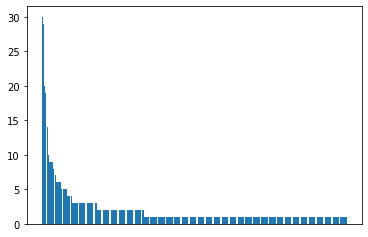

/tmp/ipykernel_7789/1329418372.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


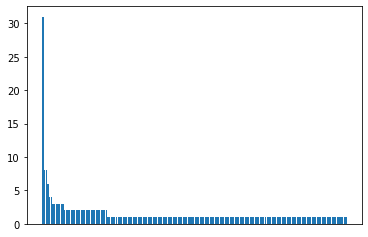

In [22]:
plt.bar(*zip(*narrative.items()))
plt.xticks([], [])
plt.show()

plt.bar(*zip(*description.items()))
plt.xticks([], [])
plt.show()

In [23]:
to_remove_word = []

for key in narrative:
    if narrative[key] > 10:
        to_remove_word.append(key)

for key in description:
    if description[key] > 10:
        to_remove_word.append(key)

In [24]:
print(to_remove_word)

['study', 'covid19', 'look', 'seek', 'include', 'information', 'virus', 'covid19']


In [26]:
resized_queries = reduce_queries(queries)

## Query Reduction

In [27]:
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augmented=False)
queries = reduce_queries(queries)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

query_id                                title  \
0        1                   coronavirus origin   
1        2  coronavirus response weather change   
2        3                 coronavirus immunity   
3        4               people die coronavirus   
4        5                 animal model covid19   

                                         description  \
0                                             origin   
1                 coronavirus respond change weather   
2   sarscov2 infect people develop immunity cross...   
3                                        cause death   
4                drug active sarscov sarscov2 animal   

                                           narrative  
0   range sarscov2 origin evolution animal source...  
1   range sarscov2 viability different weathercli...  
2   immunity develop due infection sarscov2 cross...  
3                                    mechanism death  
4   paper describe result test drug bind spike pr...

qid                                query
0   1                   coronavirus origin
1   2  coronavirus response weather change
2   3                 coronavirus immunity
3   4               people die coronavirus
4   5                 animal model covid19

qid                                              query
0   1                                             origin
1   2                 coronavirus respond change weather
2   3   sarscov2 infect people develop immunity cross...
3   4                                        cause death
4   5                drug active sarscov sarscov2 animal

qid                                              query
0   1   range sarscov2 origin evolution animal source...
1   2   range sarscov2 viability different weathercli...
2   3   immunity develop due infection sarscov2 cross...
3   4                                    mechanism death
4   5   paper describe result test drug bind spike pr...

In [28]:
# en_docs {title, abstract, both} with query_description
exp4 = experiment(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = experiment(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = experiment(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = experiment(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = experiment(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = experiment(index_en_docs_both, pq_narr, qrels)
display(exp9)

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.652  0.552  0.541400   0.672157
1         BM25  0.652  0.550  0.537541   0.669379
2  DirichletLM  0.452  0.438  0.406718   0.498428

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.736  0.696  0.637842   0.753939
1         BM25  0.736  0.690  0.628735   0.713130
2  DirichletLM  0.696  0.660  0.604594   0.667555

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.640  0.566  0.551229   0.689585
1         BM25  0.652  0.568  0.553665   0.696808
2  DirichletLM  0.496  0.454  0.420075   0.505641

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.472  0.444  0.408609   0.503427
1         BM25  0.484  0.452  0.417946   0.522432
2  DirichletLM  0.284  0.262  0.246523   0.388386

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.588  0.582  0.513255   0.557405
1         BM25  0.584  0.570  0.504015   0.564146
2  DirichletLM  0.436  0.460  0.402632   0.521106

name    P@5   P@10   nDCG@10  RR(rel=2)
0       TF_IDF  0.504  0.476  0.439259   0.562505
1         BM25  0.516  0.472  0.437417   0.561878
2  DirichletLM  0.300  0.238  0.235361   0.375800